In [4]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, FixedLocator, FixedFormatter,
                               NullLocator)

In [3]:
dirt = "/gpfswork/rech/omr/ukd13rj/nemo/penalnemov4.0.1/tests/penaloverflow/exp_up1/"

simu = [["moy_phimin01_smo0","min_phimin01_smo0","moy_phimin0001_smo0","min_phimin0001_smo0"],
        ["moy_phimin01_smo1","min_phimin01_smo1","moy_phimin0001_smo1","min_phimin0001_smo1"],
        ["moy_phimin01_smo2","min_phimin01_smo2","moy_phimin0001_smo2","min_phimin0001_smo2"],
        ["moy_phimin01_smo3","min_phimin01_smo3","moy_phimin0001_smo3","min_phimin0001_smo3"],
        ["moy_phimin01_smo4","min_phimin01_smo4","moy_phimin0001_smo4","min_phimin0001_smo4"],
        ["moy_phimin01_smo5","min_phimin01_smo5","moy_phimin0001_smo5","min_phimin0001_smo5"],
        ["moy_phimin01_smo6","min_phimin01_smo6","moy_phimin0001_smo6","min_phimin0001_smo6"],
        ["moy_phimin01_smo7","min_phimin01_smo7","moy_phimin0001_smo7","min_phimin0001_smo7"],
        ["moy_phimin01_smo8","min_phimin01_smo8","moy_phimin0001_smo8","min_phimin0001_smo8"],
        ["moy_phimin01_smo9","min_phimin01_smo9","moy_phimin0001_smo9","min_phimin0001_smo9"]]

NI,NJ = np.shape(simu)
#NI=4

pdt = "/OVF_grid_T.nc"
pdu = "/OVF_grid_U.nc"

save = 1 
dpi = 200 
psave="gridrphi.png"

def calcrphiut(_rpot,_rpou):
    """ redo the calculation of rphiut suite à la detection de l'erreur dans diawri
    """
    nk,ni = np.shape(_rpot) ; z2d = np.copy(_rpot)
    for kk in range(nk):
        for ii in range(1,ni):
            z2d[kk,ii] = np.nanmax((_rpou[kk,ii],_rpou[kk,ii-1]))/_rpot[kk,ii]
    return(z2d)
def calcrphiuu(_rpou):
    """ redo the calculation of rphiut suite à la detection de l'erreur dans diawri
    """
    nk,ni = np.shape(_rpou) ; z2d = np.copy(_rpou)
    for kk in range(nk):
        for ii in range(1,ni-1):
            z2d[kk,ii] = 0.5 * np.nanmax((_rpou[kk,ii]+_rpou[kk,ii-1],  \
                                          _rpou[kk,ii]+_rpou[kk,ii+1]))/_rpou[kk,ii]
    return(z2d)


def bringbackto10(tempfield):
    """ Return the needed 10°C water for mixing at the actual temp
        bins galère avec des poids masqués
    """
    return( (1.-tempfield.mask)*(20.-tempfield.data)/10. )

In [7]:
fig = plt.figure(figsize = (NI*4, NJ*4), dpi=dpi, constrained_layout=False)
gs = GridSpec(NJ, NI, figure=fig, wspace=0.3)

coeff = 1e3 / 20. # dx/2dt

palt = plt.get_cmap('BuPu') ; palu = plt.get_cmap('OrRd') 
optt= {"cmap" : palt, "vmin" : 1, "vmax" : 10}
optu= {"cmap" : palu, "vmin" : 1, "vmax" : 10}
font = dict(fontsize=14)

for j in range(NJ):
    for i in range(NI):
        gs0 = gs[j,i].subgridspec(1,2,wspace=0.1)
        #
        pname   = dirt+simu[i][j]+pdt
        pname_u = dirt+simu[i][j]+pdu
        """ if non existing
        """ 
        try:
            dt = nc4.Dataset(pname)
            du = nc4.Dataset(pname_u)
            ax0 = fig.add_subplot(gs0[0]) ; ax1 = fig.add_subplot(gs0[1])
        except :
            print(j,i,simu[i][j],"non existing")
            continue
        theta = np.ma.masked_outside( dt.variables['thetao_inst'][0,45:70,1,30:45], 10.,20.) 
        tmask = theta.mask
        #rphit = np.ma.masked_where(tmask, dt.variables['rphiu_t'][0,45:70,1,30:45]) * coeff
        rpot = dt.variables['rpot'][0,45:70,1,30:45]
        rpou = du.variables['rpou'][0,45:70,1,30:45]
        rphit = np.ma.masked_where(tmask,calcrphiut(rpot,rpou))
        rphiu = np.ma.masked_where(tmask,calcrphiuu(rpou))
        #if simu[i][j]!='moy_phimin0001_smo0':
        #    rphiu = np.ma.masked_where(tmask, du.variables['rphiu_u'][0,45:70,1,30:45]) * coeff
        #else : 
        #    rphiu = np.ma.masked_where(tmask, du.variables['rphiu_u'][0,45:70,1,30:45])
        dt.close() ; du.close()
        # 
        ax0.imshow(rphit, **optt) 
        ax1.imshow(rphiu, **optu) 
        #
        ax0.annotate("%s%d) " % (chr(97+j),i),
                     xy=(0., 4), xycoords='data',**font)
        maxrphit = np.nanmax(rphit) ; maxrphiu = np.nanmax(rphiu)
        ax0.annotate("%2.1f" % (maxrphit) if maxrphit<100. else "%.2e" % (maxrphit), 
                     xy=(0., 21), xycoords='data',**font)    
        ax1.annotate("%2.1f" % (maxrphiu) if maxrphiu<100. else "%.2e" % (maxrphiu), 
                     xy=(0., 21), xycoords='data',**font) 
        print(j,i,simu[i][j],"rphit %.1f rphiu %.1f" % (maxrphit,maxrphiu))
        
for i, ax in enumerate(fig.axes):
    ax.set_xticklabels([]) ; ax.set_yticklabels([])
    ax.set_xticks([])      ; ax.set_yticks([]) 
    ax.set_aspect(aspect='equal')
    ax.patch.set_color('0.8')
               
#plt.show()
print("saving : %s" % psave)
fig.savefig(psave, dpi = dpi, orientation='landscape')
plt.close()

0 0 moy_phimin01_smo0 rphit 50.5 rphiu 1.5
0 1 moy_phimin01_smo1 rphit 13.4 rphiu 2.4
0 2 moy_phimin01_smo2 rphit 4.1 rphiu 2.9
0 3 moy_phimin01_smo3 rphit 2.8 rphiu 2.5
0 4 moy_phimin01_smo4 rphit 2.2 rphiu 2.2
0 5 moy_phimin01_smo5 rphit 2.0 rphiu 1.9
0 6 moy_phimin01_smo6 rphit 1.9 rphiu 1.8
0 7 moy_phimin01_smo7 rphit 1.8 rphiu 1.7
0 8 moy_phimin01_smo8 rphit 1.7 rphiu 1.7
0 9 moy_phimin01_smo9 rphit 1.6 rphiu 1.6
1 0 min_phimin01_smo0 rphit 1.0 rphiu 50.5
1 1 min_phimin01_smo1 rphit 1.0 rphiu 13.4
1 2 min_phimin01_smo2 rphit 1.0 rphiu 4.1
1 3 min_phimin01_smo3 rphit 1.0 rphiu 2.8
1 4 min_phimin01_smo4 rphit 1.0 rphiu 2.2
1 5 min_phimin01_smo5 rphit 1.0 rphiu 2.0
1 6 min_phimin01_smo6 rphit 1.0 rphiu 1.9
1 7 min_phimin01_smo7 rphit 1.0 rphiu 1.8
1 8 min_phimin01_smo8 rphit 1.0 rphiu 1.7
1 9 min_phimin01_smo9 rphit 1.0 rphiu 1.6
2 0 moy_phimin0001_smo0 rphit 5000.5 rphiu 2500.8
2 1 moy_phimin0001_smo1 rphit 1250.9 rphiu 2.5
2 2 moy_phimin0001_smo2 rphit 313.5 rphiu 3.5
2 3 moy_phimi

---
---

In [27]:
i=0;j=3
pname   = dirt+simu[i][j]+pdt
pname_u = dirt+simu[i][j]+pdu
""" if non existing
""" 
try:
    dt = nc4.Dataset(pname)
    du = nc4.Dataset(pname_u)
    ax0 = fig.add_subplot(gs0[0]) ; ax1 = fig.add_subplot(gs0[1])
except :
    print(j,i,simu[i][j],"non existing")
theta = np.ma.masked_outside( dt.variables['thetao_inst'][0,45:70,1,30:45], 10.,20.) 
tmask = theta.mask
arphit = np.ma.masked_where(tmask, dt.variables['rphiu_t'][0,45:70,1,30:45]) * coeff
rpot = dt.variables['rpot'][0,45:70,1,30:45]
rpou = du.variables['rpou'][0,45:70,1,30:45]
rphit = np.ma.masked_where(tmask,calcrphiut(rpot,rpou))
rphiu = np.ma.masked_where(tmask, du.variables['rphiu_u'][0,45:70,1,30:45]) * coeff

maxrphit = np.nanmax(rphit) ; maxrphiu = np.nanmax(rphiu)
print(j,i,simu[i][j],"rphit %.1f rphiu %.1f" % (maxrphit,maxrphiu))

3 0 min_phimin0001_smo0 rphit 5000.5 rphiu 1.5


In [8]:
def shapi(z,n=1):
    z1d = np.copy(z); z2d = np.copy(z) ; lenz=len(z)
    for _ in range(n):
        for i in range(1,lenz-1):
            z2d[i] = 0.25 * (z1d[i-1]+2*z1d[i]+z1d[i+1])
        z1d = z2d
    return(z1d)

def calc_rphiut(_rpot,_rpou):
    """ redo the calculation of rphiut suite à la detection de l'erreur dans diawri
    """
    ni = len(_rpot) ; z2d = np.copy(_rpot)
    for ii in range(1,ni):
        z2d[ii] = np.nanmax((_rpou[ii],_rpou[ii-1]))/_rpot[ii]
    return(z2d)

def calc_rphiuu(_rpou):
    """ redo the calculation of rphiut suite à la detection de l'erreur dans diawri
    """
    ni = len(_rpou) ; z2d = np.copy(_rpou)
    for ii in range(1,ni-1):
        z2d[ii] = 0.5 * np.nanmax((_rpou[ii]+_rpou[ii-1],  \
                                   _rpou[ii]+_rpou[ii+1]))/_rpou[ii]
    return(z2d)



#n=8 ; nju=2 ; rpomin = 1e-4
n=5 ; nju=1 ; rpomin = 1e-2

N=100 
rpot = np.ones(N) ; indext=np.arange(0,N,1) ; indexu=np.arange(0,N,1)+0.5
rpot[:(N//2+1)]=rpomin
pale = plt.get_cmap('turbo',n) # high colors lame

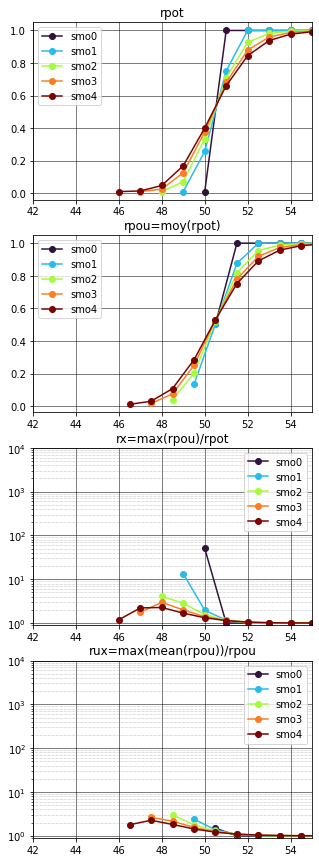

In [9]:
fig= plt.figure(figsize=(5,3*5))
gs = GridSpec(4,1, figure=fig)
ax_t = fig.add_subplot(gs[0]) 
ax_u = fig.add_subplot(gs[1]) 
ax_r = fig.add_subplot(gs[2])
ax_q = fig.add_subplot(gs[3])

for _ in np.arange(0,n,nju):
    zrpot = shapi(rpot,_)
    rpou = np.copy(zrpot)
    for i in range(1,N-1):
        rpou[i]= 0.5 * ( zrpot[i] + zrpot[i+1] ) 
    mask = zrpot<=rpomin            # all land
    mask[np.argmin(mask)-1:]=False  # first cell at phimin
    ax_t.plot(indext,np.ma.masked_where(mask,                  zrpot),'o-',label="smo%d" % (_), color = pale(_))
    ax_u.plot(indexu,np.ma.masked_where(mask,                   rpou),'o-',label="smo%d" % (_), color = pale(_))
    ax_r.plot(indext,np.ma.masked_where(mask,calc_rphiut(zrpot,rpou)),'o-',label="smo%d" % (_), color = pale(_))
    ax_q.plot(indexu,np.ma.masked_where(mask,      calc_rphiuu(rpou)),'o-',label="smo%d" % (_), color = pale(_))

ax_t.set_title('rpot')
ax_u.set_title('rpou=moy(rpot)')
ax_r.set_title('rx=max(rpou)/rpot')
ax_q.set_title('rux=max(mean(rpou))/rpou')
ax_r.set_ylim(0.9,1e4) ; ax_r.set_yscale('log')
ax_q.set_ylim(0.9,1e4) ; ax_q.set_yscale('log')

for i, ax in enumerate(fig.axes):
    ax.set_xlim(42,55)
    ax.legend(loc=0)
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')

#fig.savefig("rpoumoy%s.png" %  str(rpomin).split('.')[-1], dpi = 300)
plt.show()

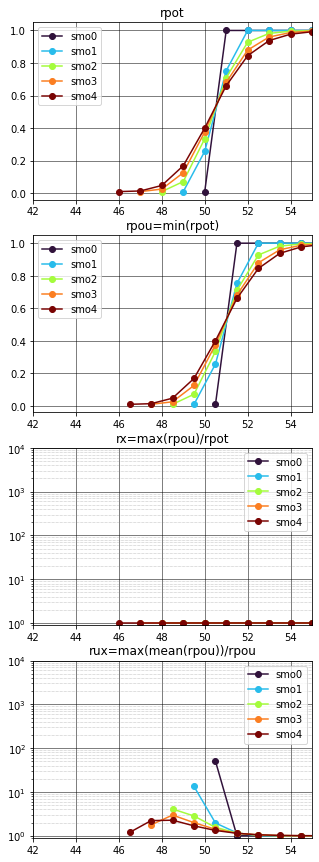

In [13]:
fig= plt.figure(figsize=(5,3*5))
gs = GridSpec(4,1, figure=fig)
ax_t = fig.add_subplot(gs[0]) 
ax_u = fig.add_subplot(gs[1]) 
ax_r = fig.add_subplot(gs[2])
ax_q = fig.add_subplot(gs[3])

for _ in np.arange(0,n,nju):
    zrpot = shapi(rpot,_)
    rpou = np.copy(zrpot)
    for i in range(1,N-1):
        rpou[i]= np.nanmin((zrpot[i], zrpot[i+1])) 
    mask = zrpot<=rpomin            # all land
    mask[np.argmin(mask)-1:]=False  # first cell at phimin
    ax_t.plot(indext,np.ma.masked_where(mask,                  zrpot),'o-',label="smo%d" % (_), color = pale(_))
    ax_u.plot(indexu,np.ma.masked_where(mask,                   rpou),'o-',label="smo%d" % (_), color = pale(_))
    ax_r.plot(indext,np.ma.masked_where(mask,calc_rphiut(zrpot,rpou)),'o-',label="smo%d" % (_), color = pale(_))
    ax_q.plot(indexu,np.ma.masked_where(mask,      calc_rphiuu(rpou)),'o-',label="smo%d" % (_), color = pale(_))

ax_t.set_title('rpot')
ax_u.set_title('rpou=min(rpot)')
ax_r.set_title('rx=max(rpou)/rpot')
ax_q.set_title('rux=max(mean(rpou))/rpou')
ax_r.set_ylim(0.9,1e4) ; ax_r.set_yscale('log')
ax_q.set_ylim(0.9,1e4) ; ax_q.set_yscale('log')

for i, ax in enumerate(fig.axes):
    ax.set_xlim(42,55)
    ax.legend(loc=0)
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')

#fig.savefig("rpoumin%s.png" % str(rpomin).split('.')[-1], dpi = 300)
plt.show()

In [111]:
N=10
rpot = np.ones(N)
rpot[:(N//2+1)]=0.01
_=0
zrpot = shapi(rpot,_)
rpou = np.copy(zrpot)
for i in range(1,N-1):
    rpou[i]= 0.5 * ( zrpot[i] + zrpot[i+1] ) 
print(zrpot)
print(rpou)
print(calc_rphiut(zrpot,rpou))
print(calc_rphiuu(rpou))

[0.01 0.01 0.01 0.01 0.01 0.01 1.   1.   1.   1.  ]
[0.01  0.01  0.01  0.01  0.01  0.505 1.    1.    1.    1.   ]
[1.00e-02 1.00e+00 1.00e+00 1.00e+00 1.00e+00 5.05e+01 1.00e+00 1.00e+00
 1.00e+00 1.00e+00]
[1.00000000e-02 1.00000000e+00 1.00000000e+00 1.00000000e+00
 2.57500000e+01 1.49009901e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


---
---
---

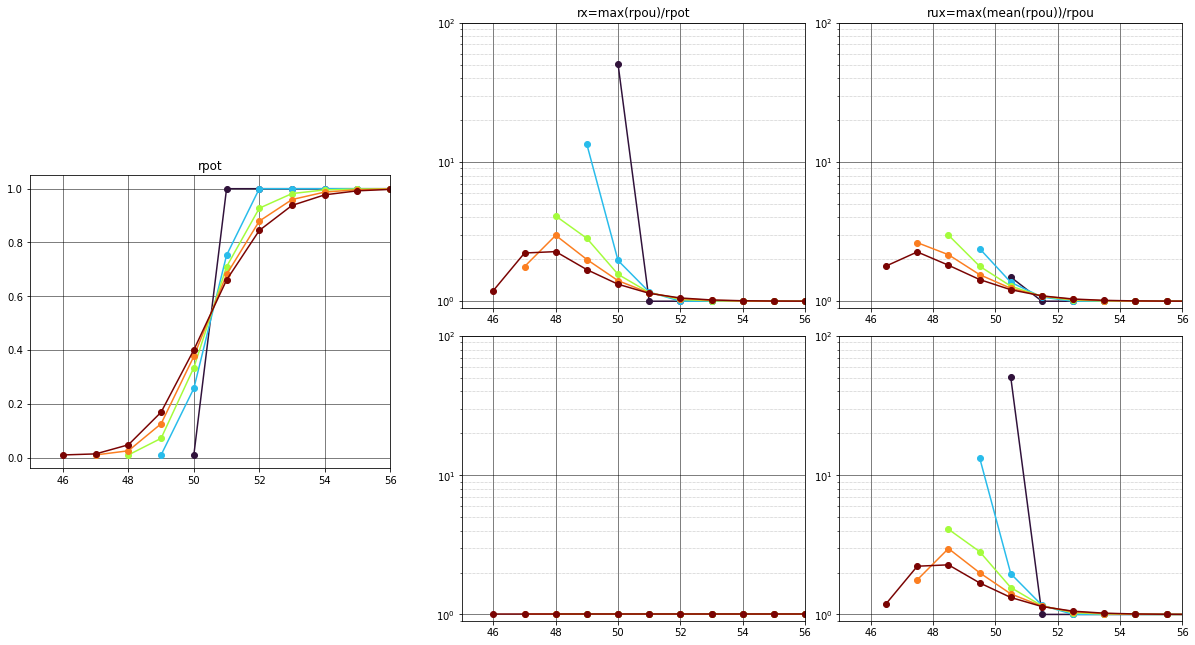

In [103]:
def shapi(z,n=1):
    z1d = np.copy(z); z2d = np.copy(z) ; lenz=len(z)
    for _ in range(n):
        for i in range(1,lenz-1):
            z2d[i] = 0.25 * (z1d[i-1]+2*z1d[i]+z1d[i+1])
        z1d = z2d
    return(z1d)

def calc_rphiut(_rpot,_rpou):
    """ redo the calculation of rphiut suite à la detection de l'erreur dans diawri
    """
    ni = len(_rpot) ; z2d = np.copy(_rpot)
    for ii in range(1,ni):
        z2d[ii] = np.nanmax((_rpou[ii],_rpou[ii-1]))/_rpot[ii]
    return(z2d)

def calc_rphiuu(_rpou):
    """ redo the calculation of rphiut suite à la detection de l'erreur dans diawri
    """
    ni = len(_rpou) ; z2d = np.copy(_rpou)
    for ii in range(1,ni-1):
        z2d[ii] = 0.5 * np.nanmax((_rpou[ii]+_rpou[ii-1],  \
                                   _rpou[ii]+_rpou[ii+1]))/_rpou[ii]
    return(z2d)



#n=8 ; nju=2 ; rpomin = 1e-4
n=5 ; nju=1 ; rpomin = 1e-2

N=100 
rpot = np.ones(N) ; indext=np.arange(0,N,1) ; indexu=np.arange(0,N,1)+0.5
rpot[:(N//2+1)]=rpomin
pale = plt.get_cmap('turbo',n) # high colors lame


""" Layout
"""
fig = plt.figure(figsize = (16,11), constrained_layout=False)
gs1 = fig.add_gridspec(nrows=3, ncols=1, left=0., right=5/6 * 6/16,
                        wspace=0., hspace=0.5/16, 
                        width_ratios=[5], height_ratios=[2.5/11,5/11,2.5/11])

ax_t = fig.add_subplot(gs1[1])

gs2 = fig.add_gridspec(nrows=2, ncols=2, left=6/16, right=1., 
                        wspace=       0.1,       hspace=0.1,
                        width_ratios=[5,5],height_ratios=[5,5])

ax_rmoy = fig.add_subplot(gs2[0,0])
ax_qmoy = fig.add_subplot(gs2[0,1])
ax_rmin = fig.add_subplot(gs2[1,0])
ax_qmin = fig.add_subplot(gs2[1,1])

""" Data
"""
for _ in np.arange(0,n,nju):
    # rpot
    zrpot = shapi(rpot,_)
    mask = zrpot<=rpomin            # all land
    mask[np.argmin(mask)-1:]=False  # first cell at phimin
    ax_t.plot(indext,np.ma.masked_where(mask,                  zrpot),'o-',label="smo%d" % (_), color = pale(_))
    # moy
    rpou = np.copy(zrpot)
    for i in range(1,N-1):
        rpou[i]= 0.5 * ( zrpot[i] + zrpot[i+1] ) 
    ax_rmoy.plot(indext,np.ma.masked_where(mask,calc_rphiut(zrpot,rpou)),'o-',label="smo%d" % (_), color = pale(_))
    ax_qmoy.plot(indexu,np.ma.masked_where(mask,      calc_rphiuu(rpou)),'o-',label="smo%d" % (_), color = pale(_))
    # min
    rpou = np.copy(zrpot)
    for i in range(1,N-1):
        rpou[i]= np.nanmin((zrpot[i], zrpot[i+1])) 
    ax_rmin.plot(indext,np.ma.masked_where(mask,calc_rphiut(zrpot,rpou)),'o-',label="smo%d" % (_), color = pale(_))
    ax_qmin.plot(indexu,np.ma.masked_where(mask,      calc_rphiuu(rpou)),'o-',label="smo%d" % (_), color = pale(_))

""" Pretty
"""


ax_t.set_title('rpot')
ax_rmoy.set_title('rx=max(rpou)/rpot')
ax_qmoy.set_title('rux=max(mean(rpou))/rpou')
ax_rmoy.set_ylim(0.9,1e2) ; ax_rmoy.set_yscale('log')
ax_qmoy.set_ylim(0.9,1e2) ; ax_qmoy.set_yscale('log')
ax_rmin.set_ylim(0.9,1e2) ; ax_rmin.set_yscale('log')
ax_qmin.set_ylim(0.9,1e2) ; ax_qmin.set_yscale('log')

for i, ax in enumerate(fig.axes):
    ax.set_xlim(45,56)
    #ax.legend(loc=0)
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')

fig.savefig("ratio1D_phimin01.png", dpi = 300)
plt.show()

In [94]:
gs2.ax

AttributeError: 'GridSpec' object has no attribute 'ax'

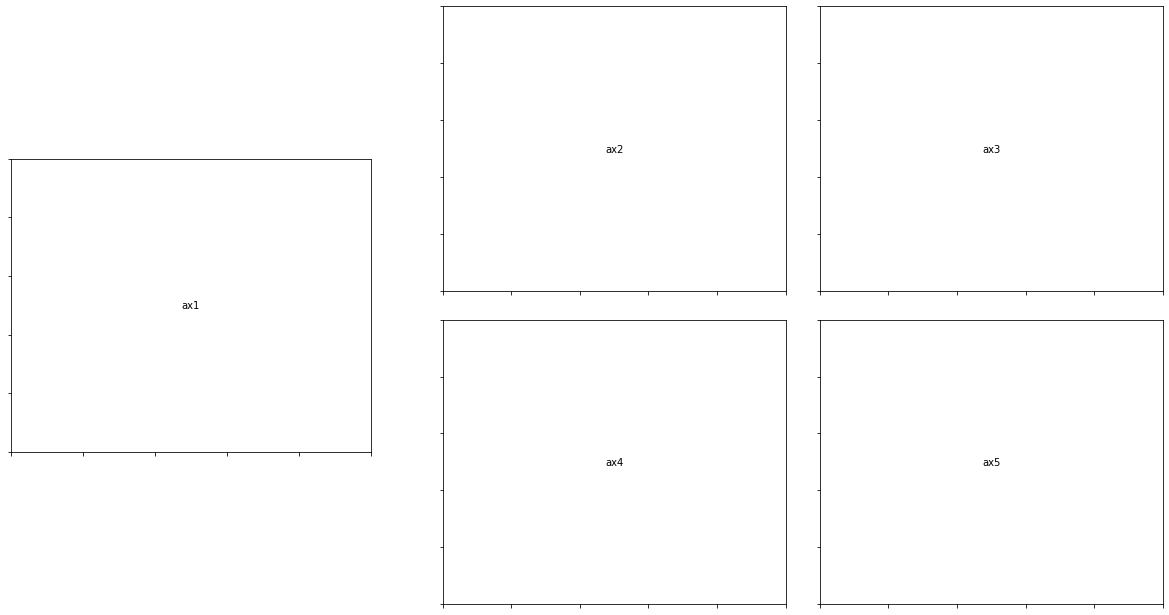

In [84]:
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig9 = plt.figure(figsize = (16,11), constrained_layout=False)
gs1 = fig9.add_gridspec(nrows=3, ncols=1, left=0., right=5/6 * 6/16,
                        wspace=0., hspace=0.5/16, 
                        width_ratios=[5], height_ratios=[2.5/11,5/11,2.5/11])
#f9_ax1 = fig9.add_subplot(gs1[0])
f9_ax2 = fig9.add_subplot(gs1[1])
#f9_ax3 = fig9.add_subplot(gs1[2])

gs2 = fig9.add_gridspec(nrows=2, ncols=2, left=6/16, right=1., 
                        wspace=       0.1,       hspace=0.1,
                        width_ratios=[5,5],height_ratios=[5,5])
f9_ax4 = fig9.add_subplot(gs2[0,0])
f9_ax5 = fig9.add_subplot(gs2[0,1])
f9_ax6 = fig9.add_subplot(gs2[1,0])
f9_ax7 = fig9.add_subplot(gs2[1,1])

format_axes(fig9)
plt.show()

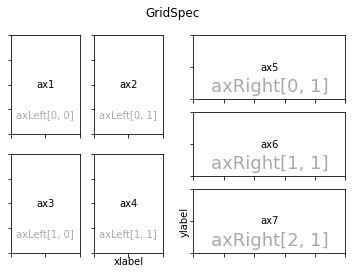

In [77]:
11/10

1.1

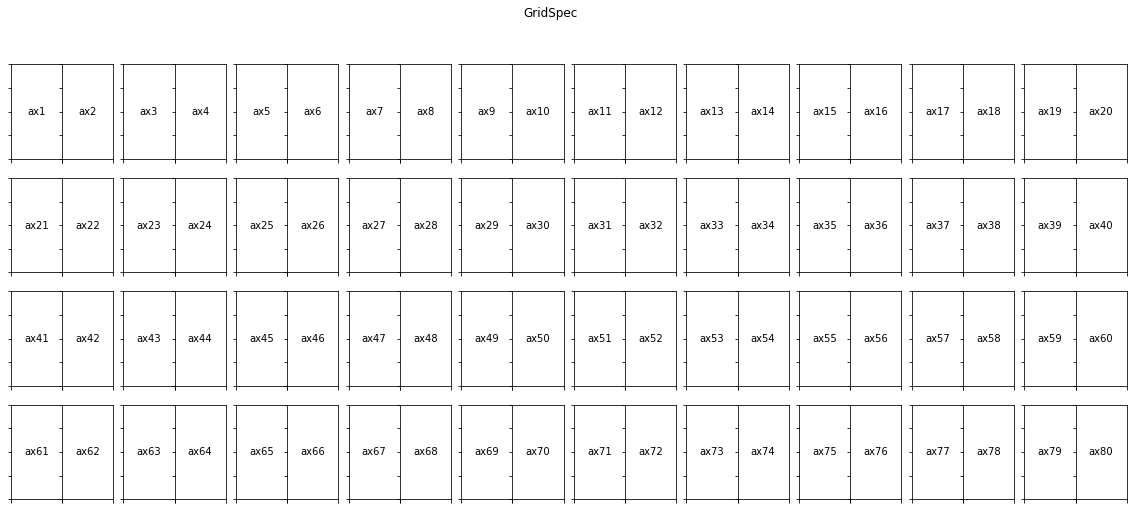

In [9]:
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(figsize = (NI*2, NJ*2), constrained_layout=False) # len of rows then len of columns
gs = GridSpec(NJ, NI, figure=fig,wspace=0.1) # j rows, i columns
for j in range(NJ):
    for i in range(NI):
        gs0 = gs[j,i].subgridspec(1,2,wspace=0.)
        ax0 = fig.add_subplot(gs0[0]) ; ax1 = fig.add_subplot(gs0[1])

fig.suptitle("GridSpec")
format_axes(fig)

plt.show()

In [28]:
"%s%d) " % (chr(97+j),i+1)

'd32) '

In [16]:
dt.variables['rphiu_t'][slicerpo]

0.9999999776482582

In [27]:
rpo = slice(0,0:70,1,0:55)

SyntaxError: invalid syntax (<ipython-input-27-1508c6267dfa>, line 1)

In [29]:
slice(1, 4, None)

slice(1, 4, None)

In [43]:
ax.value

AttributeError: 'AxesSubplot' object has no attribute 'value'